# Final Project - Jiaquan Wu
## 5/12/2021 ~ 5/17/2021
### Project name: GDP composition with economic indicator.
### Data from: World Bank database
This project I will explain the GDP or Gross Domestic Product, which is a national indicator to show how many values does the country produced in a particular period (Usually is in a year). GDP is a combination of other relational indicator, which include the final consumption of entire country, all capital’s values, government’s expenditure (or I will be said is government consumption), and the Net export’s value to other countries. Those four main indicators can explain most of the GDP and it can be found from the World bank database, it is a very creditable source.

In [1]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.3     √ purrr   0.3.4
√ tibble  3.1.0     √ dplyr   1.0.4
√ tidyr   1.1.2     √ stringr 1.4.0
√ readr   1.4.0     √ forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



### First part: Raw data process
In this project, we will using the time-serious data in across all countries.

In [2]:
#This will be the loading data from the website, but skip some information and transform it into a longer term.
transform = function (data, title) {
    files = read.csv(data, skip = 4)
    files %>% 
        select(Country.Name, X1960:X2020) %>% 
        pivot_longer(X1960:X2020, names_to = "Year", values_to = title) %>%
        separate(Year, sep = 1, into = c('X',"Year")) %>%
        select(Country.Name, Year, title) %>%
        mutate(Year = as.integer(Year))
}

In [3]:
# In this dataset, we will looking at some normal economic parameter.
full_panel = 
    transform('GDP_current.csv', "GDP") %>%
    inner_join(transform('Import.csv', "Import"), by = c("Year", "Country.Name")) %>%
    inner_join(transform('Export.csv', "Export"), by = c("Year", "Country.Name")) %>%
    inner_join(transform('Household.csv', "Consume"), by = c("Year", "Country.Name")) %>%
    inner_join(transform('CAPITAL.csv', "CAPITAL"), by = c("Year", "Country.Name")) %>%
    inner_join(transform('GOV_INVEST.csv', "GOV_INVEST"), by = c("Year", "Country.Name")) %>%
    mutate(Net_Export = Export - Import)

Note: Using an external vector in selections is ambiguous.
i Use `all_of(title)` instead of `title` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [4]:
# This function will seperate one dataset to 3 different dataset, and the percentage will be 60%, 20% and 20%
sep622 = function (file, percent = 0.6) {
    file0 = mutate(file, id = row_number())
    file1 = sample_frac(file0,percent)
    file2 = anti_join(file0,file1, by = "id")
    file3 = sample_frac(file2,0.5)
    file2 = anti_join(file2,file3, by = "id")
    list(file1, file2, file3)
}

In [5]:
out = sep622(full_panel)
train = as.data.frame(out[1])
valid = as.data.frame(out[2])
test = as.data.frame(out[3])

In [6]:
print(as.tibble(train), n = 10)

Warning message:
"`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


# A tibble: 9,662 x 10
   Country.Name   Year      GDP    Import    Export  Consume  CAPITAL GOV_INVEST
   <chr>         <int>    <dbl>     <dbl>     <dbl>    <dbl>    <dbl>      <dbl>
 1 Uzbekistan     1995  1.34e10  NA        NA        5.87e 9  3.23e 9    4.27e 9
 2 Hungary        2009  1.31e11   9.20e10   9.73e10  7.01e10  2.65e10    2.89e10
 3 Kiribati       1969 NA        NA        NA       NA       NA         NA      
 4 Puerto Rico    2005  8.39e10   3.89e10   5.65e10  4.71e10  1.22e10    1.01e10
 5 Cameroon       1973  1.76e 9   4.22e 8   3.64e 8  1.26e 9  3.50e 8    2.03e 8
 6 Tonga          2016  4.21e 8   2.71e 8   1.08e 8 NA       NA         NA      
 7 American Sam~  2019 NA        NA        NA       NA       NA         NA      
 8 French Polyn~  2009 NA        NA        NA       NA       NA         NA      
 9 Brazil         1985  2.23e11   1.58e10   2.73e10  1.47e11  4.28e10    2.20e10
10 North America  1981  3.51e12   3.97e11   3.87e11  2.10e12  8.57e11    5.73e11
# ...

Until this time, we seperate those data into 6/2/2 with training, validation and test dataset. Becuase we need a predict unseen data's model, not a single dataset's model.  
### Part two: Each individual regression model:


Call:
lm(formula = GDP ~ Consume, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.798e+12 -1.945e+10 -1.292e+10 -1.129e+10  5.259e+12 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.225e+10  5.940e+09   2.063   0.0392 *  
Consume     1.734e+00  1.832e-03 946.141   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.447e+11 on 5935 degrees of freedom
  (3725 observations deleted due to missingness)
Multiple R-squared:  0.9934,	Adjusted R-squared:  0.9934 
F-statistic: 8.952e+05 on 1 and 5935 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3725 rows containing missing values (geom_point)."


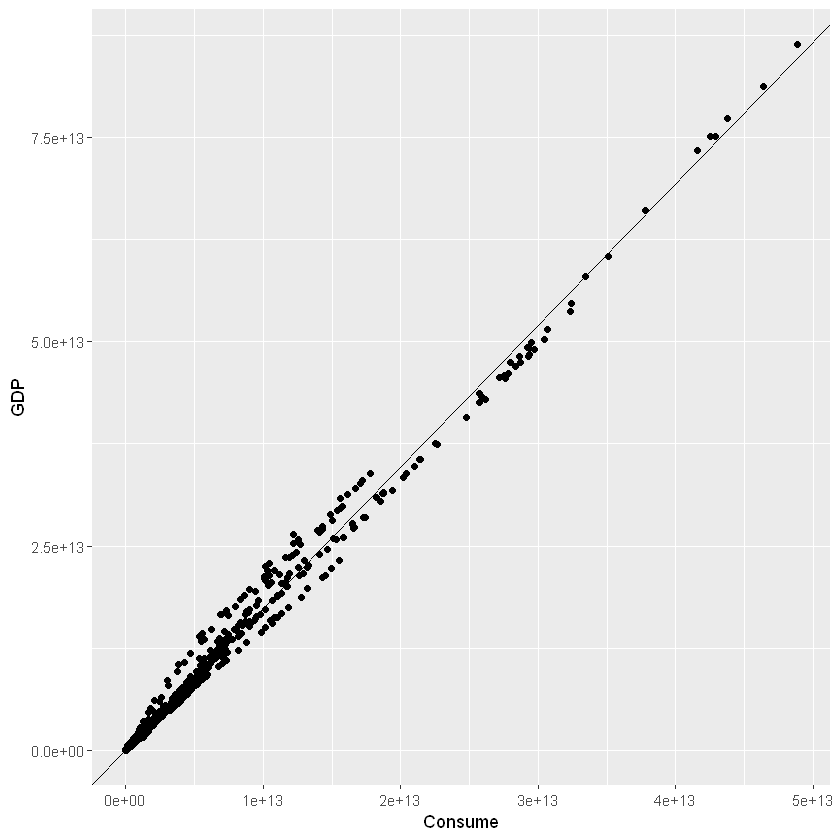

In [7]:
G_C = lm(GDP ~ Consume, data = train) #Model
summary(G_C) #Model output

ggplot(train) + 
    geom_point(aes(x =Consume , y = GDP)) + 
    geom_abline(aes(intercept = G_C$coef[1], slope = G_C$coef[2])) #Graph


Call:
lm(formula = GDP ~ CAPITAL, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-9.760e+12 -1.036e+10 -8.946e+09  2.768e+09  1.012e+13 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.718e+09  1.332e+10    0.73    0.466    
CAPITAL     3.828e+00  9.208e-03  415.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.985e+11 on 5960 degrees of freedom
  (3700 observations deleted due to missingness)
Multiple R-squared:  0.9667,	Adjusted R-squared:  0.9667 
F-statistic: 1.728e+05 on 1 and 5960 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3700 rows containing missing values (geom_point)."


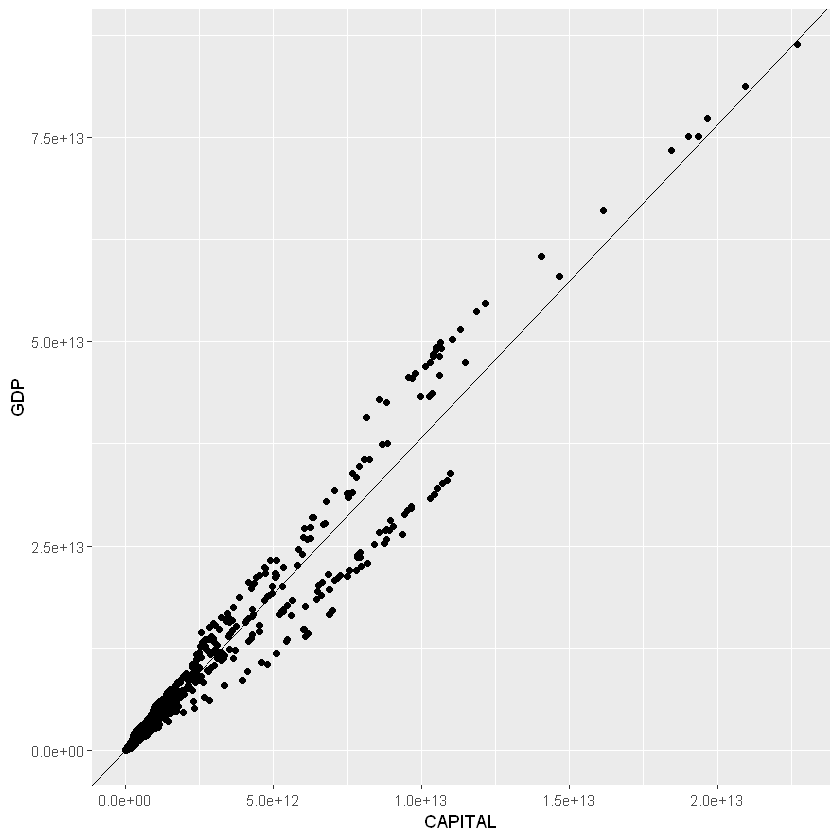

In [8]:
G_CA = lm(GDP ~ CAPITAL, data = train)
summary(G_CA)

ggplot(train) + 
    geom_point(aes(x =CAPITAL , y = GDP)) + 
    geom_abline(aes(intercept = G_CA$coef[1], slope = G_CA$coef[2]))


Call:
lm(formula = GDP ~ GOV_INVEST, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-5.393e+12 -4.606e+10 -4.444e+10 -2.132e+10  3.886e+12 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.522e+10  6.237e+09   7.251 4.67e-13 ***
GOV_INVEST  5.844e+00  6.493e-03 900.048  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.673e+11 on 5928 degrees of freedom
  (3732 observations deleted due to missingness)
Multiple R-squared:  0.9927,	Adjusted R-squared:  0.9927 
F-statistic: 8.101e+05 on 1 and 5928 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3732 rows containing missing values (geom_point)."


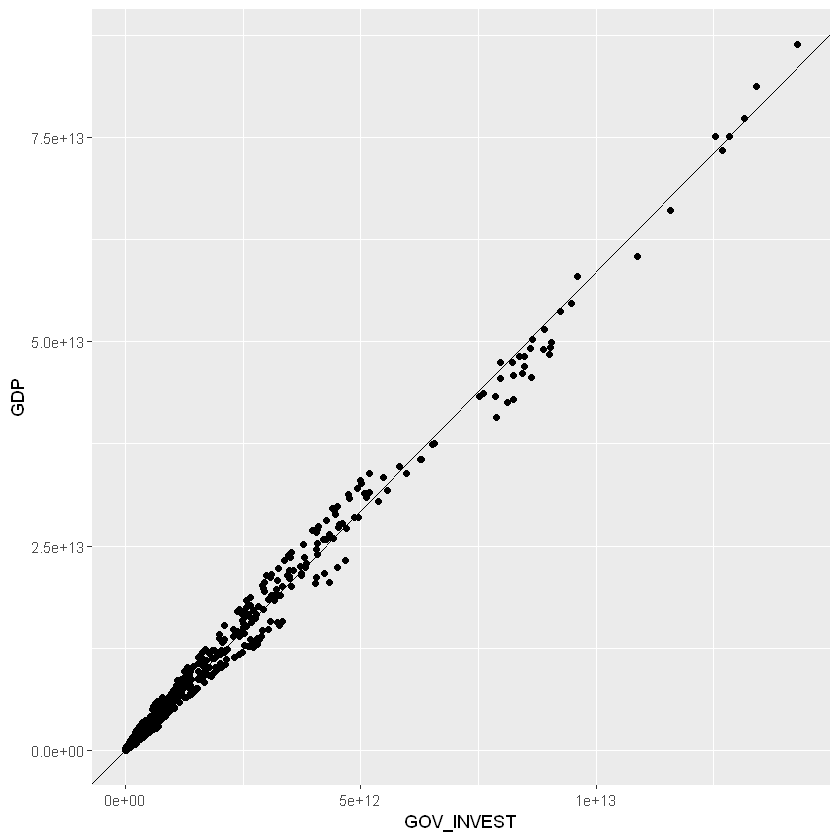

In [9]:
G_G = lm(GDP ~ GOV_INVEST, data = train)
summary(G_G)

ggplot(train) + 
    geom_point(aes(x =GOV_INVEST , y = GDP)) + 
    geom_abline(aes(intercept = G_G$coef[1], slope = G_G$coef[2]))


Call:
lm(formula = GDP ~ Import, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.035e+13 -9.738e+10 -8.775e+10 -8.004e+10  9.982e+12 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.726e+10  1.253e+10   6.966  3.6e-12 ***
Import      3.636e+00  8.476e-03 428.992  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.692e+11 on 6287 degrees of freedom
  (3373 observations deleted due to missingness)
Multiple R-squared:  0.967,	Adjusted R-squared:  0.967 
F-statistic: 1.84e+05 on 1 and 6287 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3373 rows containing missing values (geom_point)."


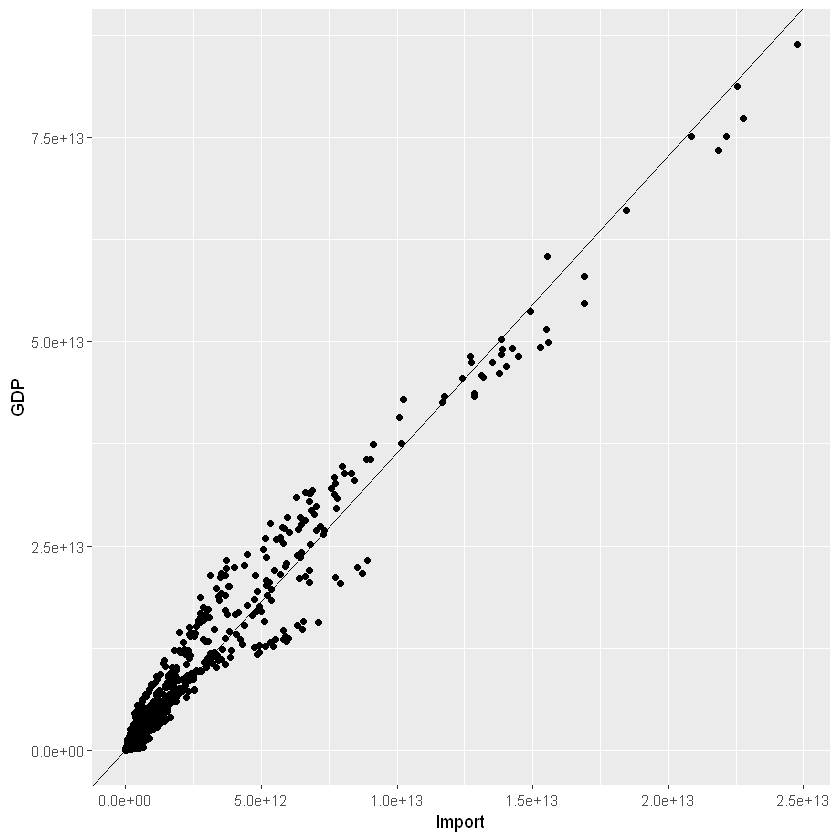

In [10]:
G_I = lm(GDP ~ Import, data = train)
summary(G_I)

ggplot(train) + 
    geom_point(aes(x =Import , y = GDP)) + 
    geom_abline(aes(intercept = G_I$coef[1], slope = G_I$coef[2]))


Call:
lm(formula = GDP ~ Export, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.181e+13 -1.017e+11 -9.568e+10 -8.128e+10  1.245e+13 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.579e+10  1.439e+10   6.659 2.99e-11 ***
Export      3.533e+00  9.501e-03 371.817  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.112e+12 on 6277 degrees of freedom
  (3383 observations deleted due to missingness)
Multiple R-squared:  0.9566,	Adjusted R-squared:  0.9566 
F-statistic: 1.382e+05 on 1 and 6277 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3383 rows containing missing values (geom_point)."


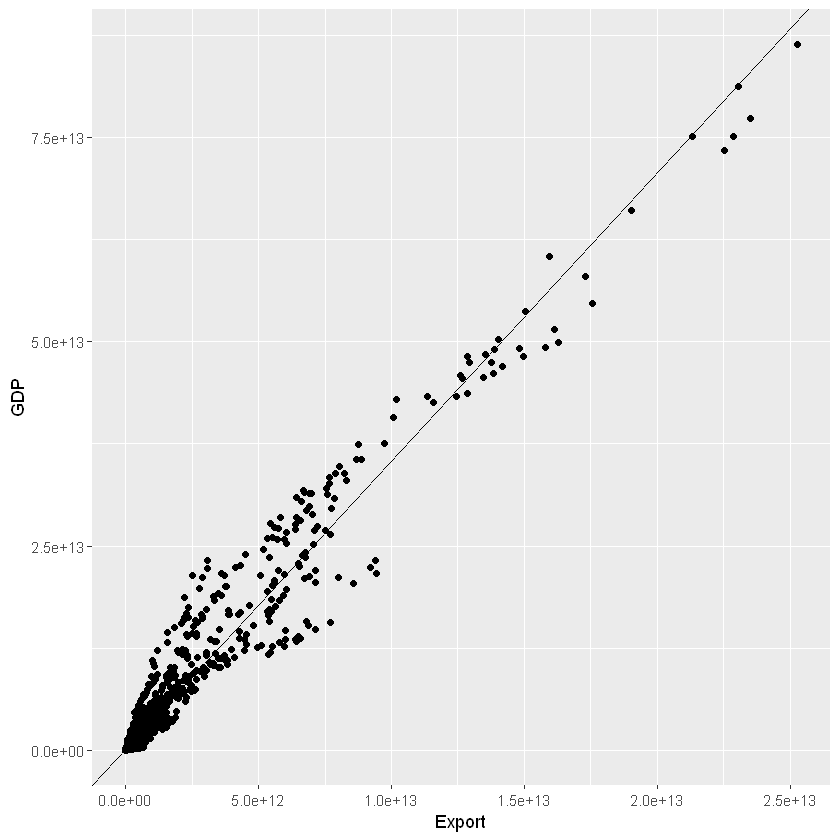

In [11]:
G_E = lm(GDP ~ Export, data = train)
summary(G_E)

ggplot(train) + 
    geom_point(aes(x =Export , y = GDP)) + 
    geom_abline(aes(intercept = G_E$coef[1], slope = G_E$coef[2]))

As we can see from the above, each of the variables can explain the relationship between the GDP itself. The only difference is the variance or error between those data. We can see that Import, Export, and capital will have a larger variance than the other two (Consumption and Government expenditure). Maybe our model will have an accuracy problem because of the variance problem. However, as the data show about itself, they all have a strong positive relationship (almost like a 45-degree line, which is 1 change in the indicator will cause GDP to add 1) between the GDP.
#### RMSE for each invidual

In [12]:
RMSE <- function(a, data) {
    preds <- a[1] + data$x * a[2]
    diffs <- data$y - preds
    sqrt(mean(diffs^2, na.rm = T))
}

I use the Root Mean Standard Error to testing the Error's mean of the modeling.

In [13]:
RMSE(G_C$coef, data = transmute(na.omit(valid), x = Consume, y = GDP)) # RMSE value
RMSE(G_CA$coef, data = transmute(na.omit(valid), x = CAPITAL, y = GDP))
RMSE(G_G$coef, data = transmute(na.omit(valid), x = GOV_INVEST, y = GDP))
RMSE(G_I$coef, data = transmute(na.omit(valid), x = Import, y = GDP))
RMSE(G_E$coef, data = transmute(na.omit(valid), x = Export, y = GDP))

[1] 443817580455

[1] 1.010205e+12

[1] 498542331575

[1] 1.181785e+12

[1] 1.342644e+12

You can see from the RMSE score, the error term seems a little bit large from the dataset. However, as we look inside of the data itself, all of the data is very large to use. Like in the GDP dataset, the difference can be `14279 Billion` compare to the Error value `1356 Billion`. So we use the international unit of measurement, billion to measure the RMSE value. It will show like this.

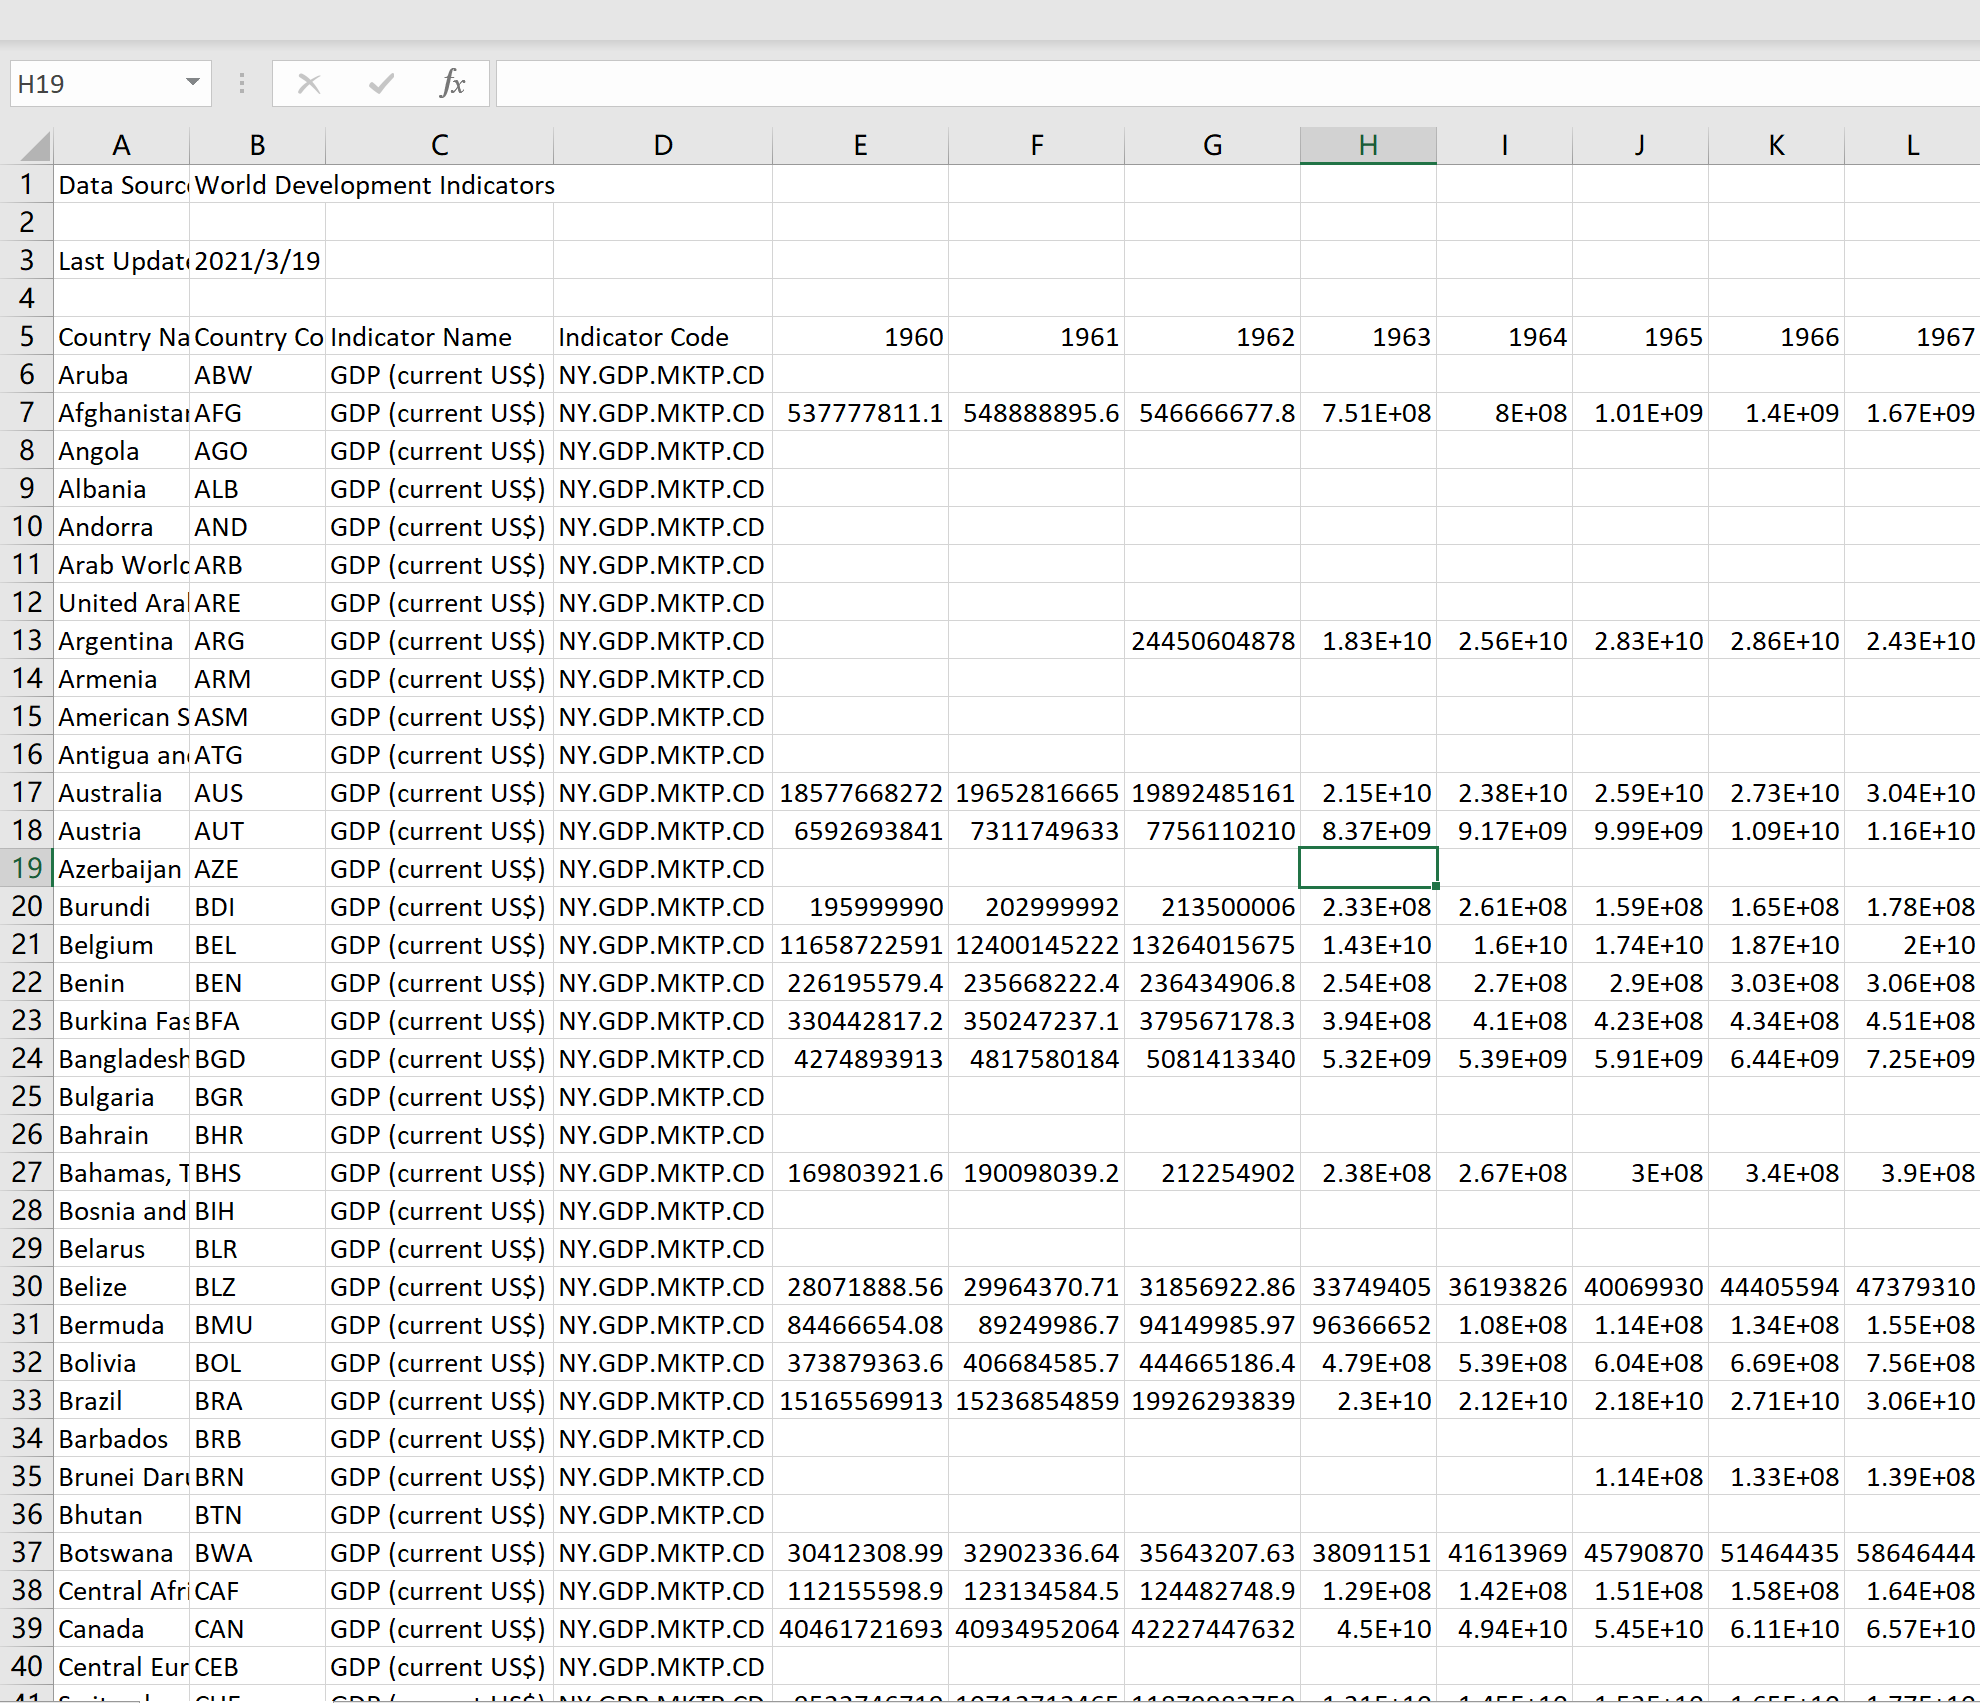

In [14]:
RMSE(G_C$coef, data = transmute(na.omit(valid), x = Consume, y = GDP))  / 1000000000# RMSE value
RMSE(G_CA$coef, data = transmute(na.omit(valid), x = CAPITAL, y = GDP)) / 1000000000
RMSE(G_G$coef, data = transmute(na.omit(valid), x = GOV_INVEST, y = GDP)) / 1000000000
RMSE(G_I$coef, data = transmute(na.omit(valid), x = Import, y = GDP)) / 1000000000
RMSE(G_E$coef, data = transmute(na.omit(valid), x = Export, y = GDP)) / 1000000000

[1] 443.8176

[1] 1010.205

[1] 498.5423

[1] 1181.785

[1] 1342.644

For the error term in those models, as the value of each variable is very large, so the Error term is hardly predicted. However, we can see from those RMSE scores, the Consume and GOV_INVEST are much smaller than the other 3 variables. So, we can say they are the main variables to predict the GDP.

#### Take \<Net Export> as a variable


Call:
lm(formula = GDP ~ Net_Export, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.065e+13 -1.096e+12 -1.074e+12 -9.013e+11  7.299e+13 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.099e+12  6.363e+10   17.26   <2e-16 ***
Net_Export  2.384e+01  8.315e-01   28.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.019e+12 on 6274 degrees of freedom
  (3386 observations deleted due to missingness)
Multiple R-squared:  0.1159,	Adjusted R-squared:  0.1157 
F-statistic: 822.2 on 1 and 6274 DF,  p-value: < 2.2e-16


Warning message:
"Removed 3386 rows containing missing values (geom_point)."


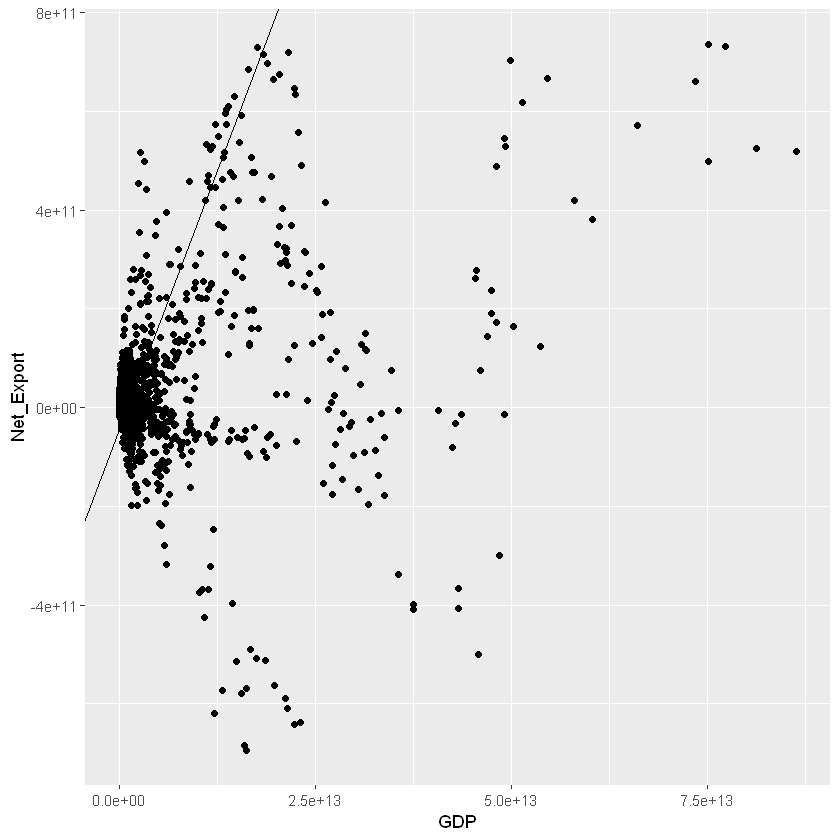

In [15]:
G_NE = lm(GDP ~ Net_Export, data = train)
summary(G_NE)

ggplot(train) + 
    geom_point(aes(x =Net_Export , y = GDP)) + 
    geom_abline(aes(intercept = G_NE$coef[1], slope = G_NE$coef[2])) + 
    coord_flip()

From the economic's thought, the total export itself cannot explain much of the GDP, because the country will be using the import as a replacement of domestic goods shortage, it will lower the GDP. As the replacement, they may export some goods to increase the GDP. Back and forward, the Total Net Export will be an indicator that explains how much goods this country offers to the world as extra production.  
In this chart, we can see most of the counties is around 0 in the Net Export, and it shows positive distributions across the negative and positive export. However, in the positive net export countries, their GDP is more than the negative net export countries. So we can conclude that if counties have more net export, the possibility of "high GDP counties" will become higher.
### Part three: Full panel Linear Model

In [16]:
Linear_model = lm(GDP ~ Consume+CAPITAL+GOV_INVEST+Export+Import, data = train)
summary(Linear_model)


Call:
lm(formula = GDP ~ Consume + CAPITAL + GOV_INVEST + Export + 
    Import, data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.850e+11  1.304e+09  1.856e+09  1.927e+09  1.276e+11 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -1.894e+09  2.089e+08   -9.064   <2e-16 ***
Consume      1.001e+00  8.151e-04 1227.573   <2e-16 ***
CAPITAL      1.001e+00  6.029e-04 1660.488   <2e-16 ***
GOV_INVEST   9.416e-01  2.992e-03  314.713   <2e-16 ***
Export       9.671e-01  4.074e-03  237.388   <2e-16 ***
Import      -9.323e-01  4.638e-03 -201.021   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.528e+10 on 5736 degrees of freedom
  (3920 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.523e+08 on 5 and 5736 DF,  p-value: < 2.2e-16


In the full panel model, we will use all of the variables from above to make a model predict the GDP.  
From the Linear_model summary, we can see those variables are very significant in each area. So, I can explain some estimate coefficients and standard errors about it.  
At first, is the intercept of this model, which is the base of the GDP consumption. The coefficient of this variable is -1.674 billion, which is the average start point of this model. However, the Standard Error of this parameter is 21 million, so it explains most of the difference or error terms are from each country's base GDP.  We can say the GDP is still based on a country’s history value of GDP. Then, is each explanatory variable. Consume, as the coefficient around 1 and STD is 0.0008872, it shows the as the Consume increase 1.001, the total GDP will incline 1. Same with the other 4 variables, as Capital investment incline 0.9972, or Government investment incline 0.9535, the total GDP will incline 1. The standard error of those variables is very small and showing the coefficient of each variable can have more accuracy on the prediction.

In [17]:
Linear_model_NE = lm(GDP ~ Consume+CAPITAL+GOV_INVEST+Net_Export, train)
summary(Linear_model_NE)


Call:
lm(formula = GDP ~ Consume + CAPITAL + GOV_INVEST + Net_Export, 
    data = train)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.005e+11  1.931e+09  2.180e+09  2.276e+09  1.555e+11 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -2.178e+09  2.300e+08   -9.469   <2e-16 ***
Consume      1.004e+00  8.932e-04 1123.535   <2e-16 ***
CAPITAL      1.001e+00  6.643e-04 1507.087   <2e-16 ***
GOV_INVEST   9.838e-01  3.019e-03  325.908   <2e-16 ***
Net_Export   1.037e+00  3.920e-03  264.501   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.684e+10 on 5737 degrees of freedom
  (3920 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.568e+08 on 4 and 5737 DF,  p-value: < 2.2e-16


If we using the net export as the variable to replace the export and import variables, most of the variable's coefficient will not change. But the Net_Export's coefficient shows us a positive relationship with the GDP. 
#### RMSE score for the Full Linear model

In [18]:
RMSE5 <- function(a, data) {
    preds <- a[1] + data$x1 * a[2] + data$x2 * a[3] + data$x3 * a[4] + data$x4 * a[5] + data$x5 * a[6]
    diffs <- data$y - preds
    sqrt(mean(diffs^2))
}

In [19]:
RMSE4 <- function(a, data) {
    preds <- a[1] + data$x1 * a[2] + data$x2 * a[3] + data$x3 * a[4] + data$x4 * a[5]
    diffs <- data$y - preds
    sqrt(mean(diffs^2))
}

In [20]:
RMSE5(Linear_model$coef, data = mutate(na.omit(valid), x1 = Consume, x2 = CAPITAL, x3 = GOV_INVEST, x4 = Export, x5 = Import, y = GDP)) / 1000000000
RMSE4(Linear_model_NE$coef, data = mutate(na.omit(valid), x1 = Consume, x2 = CAPITAL, x3 = GOV_INVEST, x4 = Net_Export, y = GDP)) / 1000000000

[1] 16.08594

[1] 16.5491

From the RMSE score prediction, we can see the score have a little bit different between the net_export model and the full panel model. Seems the full panel model can have a smaller RMSE score than the other, and if we compare to the above (Individual RMSE score), the full panel RMSE score is much smaller. So using the 5 variable's modeling can predict the GDP more accurately. 
### Part four: Using the testing dataset to test the model

In [21]:
RMSE5(Linear_model$coef, data = mutate(na.omit(test), x1 = Consume, x2 = CAPITAL, x3 = GOV_INVEST, x4 = Export, x5 = Import, y = GDP)) / 1000000000

[1] 15.58195

From the testing dataset, we can see the RMSE score is even smaller than the validation dataset. So we can assume this model is a successful prediction of the GDP. And for a better view of the difference between prediction and real value, I create the following data

In [22]:
pre_linear5 <- function(a, data) {
    preds <- a[1] + data$x1 * a[2]+ data$x2 * a[3]+ data$x3 * a[4]+ data$x4 * a[5]+ data$x5 * a[6]  # get predictions
    transmute(data, GDP = data$y, Model_Predict = preds, diff = GDP - Model_Predict)
}

In [23]:
as.tibble(pre_linear5(Linear_model$coef, data = transmute(na.omit(test), x1 = Consume, x2 = CAPITAL, x3 = GOV_INVEST, x4 = Export, x5 = Import, y = GDP))) %>%
print(n = 10)

# A tibble: 1,896 x 3
       GDP Model_Predict          diff
     <dbl>         <dbl>         <dbl>
 1 1.21e 9      -8.16e 8   2026131879.
 2 5.51e11       5.56e11  -5490793454.
 3 9.98e10       9.48e10   4960952038.
 4 2.52e12       2.57e12 -50487385991.
 5 9.59e10       9.49e10   1038268670.
 6 1.32e10       1.14e10   1825100875.
 7 5.64e 9       3.72e 9   1914966877.
 8 4.83e10       4.67e10   1532412854.
 9 8.34e 9       6.60e 9   1741415163.
10 3.65e11       3.71e11  -6772749378.
# ... with 1,886 more rows


This is a prediction dataset, the first col is the GDP from the real value (from the World bank), and the second col is the model's prediction value of the GDP. The different (third col) show how many values is the error term are. But the value is too large to talk about it, so we use the normal unit of measurement, transform into Billion dollars to take a look.

In [24]:
pre_linear5_billion <- function(a, data) {
    preds <- a[1] + data$x1 * a[2]+ data$x2 * a[3]+ data$x3 * a[4]+ data$x4 * a[5]+ data$x5 * a[6]  # get predictions
    transmute(data, GDP = data$y / 1000000000, Model_Predict = preds / 1000000000, diff = GDP - Model_Predict)
}

In [25]:
as.tibble(pre_linear5_billion(Linear_model$coef, data = transmute(na.omit(test), x1 = Consume, x2 = CAPITAL, x3 = GOV_INVEST, x4 = Export, x5 = Import, y = GDP))) %T>%
print(n = 10)%>%
summary()

# A tibble: 1,896 x 3
       GDP Model_Predict   diff
     <dbl>         <dbl>  <dbl>
 1    1.21        -0.816   2.03
 2  551.         556.     -5.49
 3   99.8         94.8     4.96
 4 2516.        2567.    -50.5 
 5   95.9         94.9     1.04
 6   13.2         11.4     1.83
 7    5.64         3.72    1.91
 8   48.3         46.7     1.53
 9    8.34         6.60    1.74
10  365.         371.     -6.77
# ... with 1,886 more rows


      GDP           Model_Predict           diff          
 Min.   :    0.03   Min.   :   -1.87   Min.   :-182.0907  
 1st Qu.:    4.28   1st Qu.:    2.41   1st Qu.:   1.2648  
 Median :   34.05   Median :   31.84   Median :   1.8429  
 Mean   : 1374.81   Mean   : 1374.97   Mean   :  -0.1542  
 3rd Qu.:  336.20   3rd Qu.:  337.60   3rd Qu.:   1.9261  
 Max.   :87734.57   Max.   :87723.61   Max.   :  86.7285  

We can see the most of the difference is around -0.27 billion dollars, so it is close to the real value. The model can predict GDP successfully.
### Part5: Summary and Full model

In [26]:
Linear_Full_model = lm(GDP ~ Consume+CAPITAL+GOV_INVEST+Export+Import, data = full_panel)
summary(Linear_Full_model)


Call:
lm(formula = GDP ~ Consume + CAPITAL + GOV_INVEST + Export + 
    Import, data = full_panel)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.852e+11  1.332e+09  1.820e+09  1.890e+09  1.288e+11 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.854e+09  1.638e+08  -11.32   <2e-16 ***
Consume      1.002e+00  6.466e-04 1549.04   <2e-16 ***
CAPITAL      9.988e-01  4.825e-04 2070.26   <2e-16 ***
GOV_INVEST   9.473e-01  2.382e-03  397.68   <2e-16 ***
Export       9.783e-01  3.133e-03  312.30   <2e-16 ***
Import      -9.478e-01  3.522e-03 -269.08   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.546e+10 on 9549 degrees of freedom
  (6549 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.518e+08 on 5 and 9549 DF,  p-value: < 2.2e-16


As we can see from the above, I use the data from the world bank to create a GDP model. Which is:  
`GDP = -1854000000 + 1.002Consume + 0.9988CAPITAL + 0.9473GOV_INVEST + 0.9783Export - 0.9478Import`  
I explain much of the prediction process and the accuracy around it. Even this model still has some random error terms from the original GDP, but most of the GDP can be explainable from this model. 

### Extra: Show the full model with plot

In [27]:
temp1 = full_panel %>% pivot_longer(Import:Net_Export, names_to = 'Type', values_to = 'Value')
(tlm = lm(data = temp1, GDP~Value))


Call:
lm(formula = GDP ~ Value, data = temp1)

Coefficients:
(Intercept)        Value  
  4.471e+11    2.618e+00  


Warning message:
"Removed 6227 rows containing missing values (geom_point)."
Warning message:
"Removed 6185 rows containing missing values (geom_point)."
Warning message:
"Removed 6224 rows containing missing values (geom_point)."
Warning message:
"Removed 5628 rows containing missing values (geom_point)."
Warning message:
"Removed 5612 rows containing missing values (geom_point)."


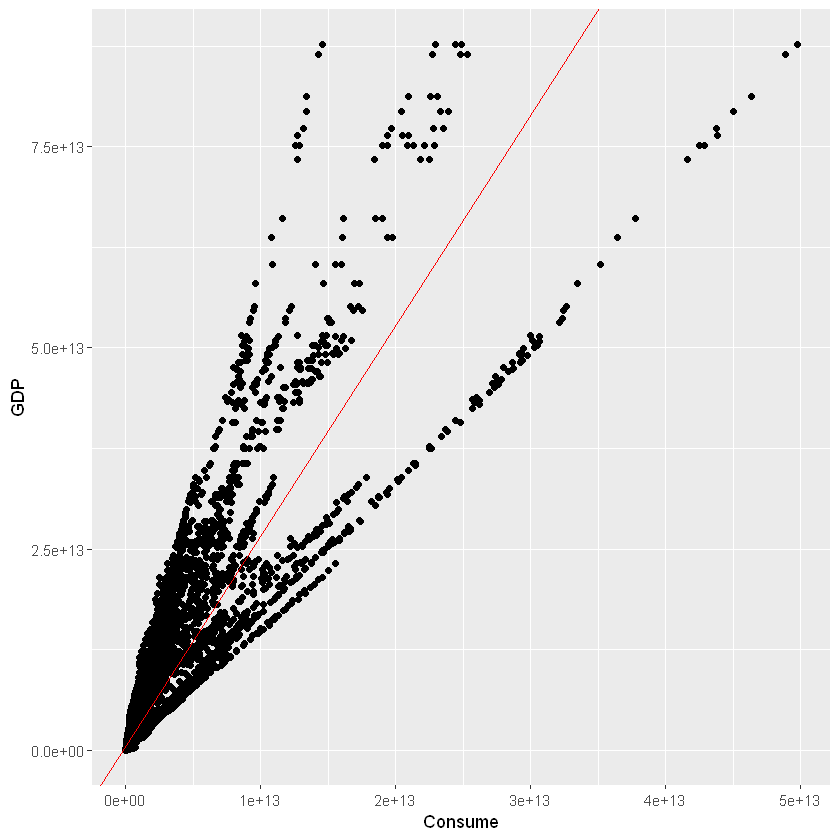

In [28]:
full_panel %>%
    ggplot() + geom_point(aes(x = Consume, y = GDP)) + 
    geom_point(aes(x = CAPITAL, y = GDP)) + 
    geom_point(aes(x = GOV_INVEST, y = GDP)) + 
    geom_point(aes(x = Export, y = GDP)) + 
    geom_point(aes(x = Import, y = GDP)) + 
    geom_abline(aes(intercept = tlm$coef[1], slope = tlm$coef[2]), color = 'red')

I dont know this plot is a fit line or not.